Import required variables

In [1]:
import os
import sys
import json
import random
import logging
import numpy as np
import seaborn as sns
from tqdm import tqdm
from ultralytics import *
from environment import *
from channel_model import *
from task_managment import *
import matplotlib.pyplot as plt

Error reading from C:\Users\alvar\AppData\Roaming\Ultralytics\settings.json: "No Ultralytics setting 'openvino_msg'. \nView Ultralytics Settings with 'yolo settings' or at 'C:\\Users\\alvar\\AppData\\Roaming\\Ultralytics\\settings.json'\nUpdate Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings."
Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\alvar\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Initialize scenario

In [2]:
#Time parameters
time_step = 0.001 # 1ms

# User parameters
area_size = 300 #meters
N_users = 10
local_processing_storage = 800e6
local_queue_storage = 8e9 # bits
offloader_queue_storage = 8e9 # bits
power_user = 2 # W, using the values for Snapdragon 7 Gen 3 (mid-end commercially available mobile CPU) considering heavy CPU usage (GPU not used)
f_user = 1.5e9 # Realistic value for the CPU to be fully active
user_available_energy = 40e4 # Joules

# Task Parameters
task_number = 1
generation_probability = time_step * task_number  # 1 per second
if generation_probability > 1:
    generation_probability = 1
latency_deadline = 3 # s
latency_sensitive_deadline = 1.2 # s
latency_threshold = 1.5   # s
energy_threshold = 2.5  # in Joules

#UAV parameters
radius = 75
center = [area_size/2, area_size/2]
uav_altitude = 50 #meters
uav_speed = 5 #m/s
uav_mass = 4 #kg
uav_available_energy = 3e6 #Joule
power_uav = 2*6 # W, using the values for Snapdragon 7 Gen 3
f_uav = 3.2 * 2 * 1.5e9 # 2 CPus for the UAV
uav_speed_ratio = f_uav/f_user # times faster than local CPU
uav_processing_storage = 16e9
uav_queue_storage = 8e12 # bits

# Channel parameters
carrier_freq = 28e9
K_dB = 10  # Rician K-factor in dB
K_factor_constant = 10 ** (K_dB / 10) # Strong LOS case, constant K
tx_power = 1  #W
total_bandwidth = 400e6  # 400 MHz bandwidth
bandwidth = total_bandwidth/(N_users + 1) # Equal division of bandwidth among users and UAV 
noise_power_density = 5e-18  # W/Hz
noise_power = bandwidth * noise_power_density  # W

# YOLO Model
model = YOLO("yolov3.pt")# Load YOLOv3 model
logging.getLogger("ultralytics").setLevel(logging.CRITICAL) # Disable printing output
tqdm.disable = True


# Initialize UAV
uav = UAV(center,radius,uav_altitude,uav_speed,uav_mass,uav_available_energy,power_uav,uav_speed_ratio,
          Queue(uav_queue_storage),
          Processor(uav_processing_storage, time_step),
          f_uav, time_step)
uav.compute_trajectory(time_step)
uav_positions = np.array(uav.trajectory) # all the possible UAV coordinates

# Initialize users
users = [User(area_size,
              i,
              Queue(local_queue_storage),
              Processor(local_processing_storage,time_step),
              Offloader(Queue(offloader_queue_storage),time_step),
              power_user,
              f_user,
              user_available_energy)
         for i in range(N_users)]

PRO TIP  Replace 'model=yolov3.pt' with new 'model=yolov3u.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



Plot the initial scenario

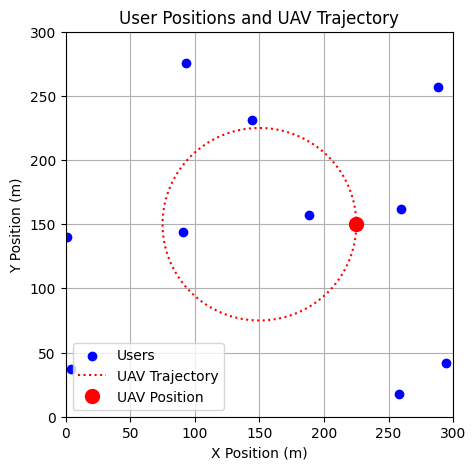

In [3]:
# Extract user coordinates for plotting
x_coords_users = [user.position[0] for user in users]
y_coords_users = [user.position[1] for user in users]
# Extract UAV trajectory for plotting
x_coords_circle = [point[0] for point in uav.trajectory]
y_coords_circle = [point[1] for point in uav.trajectory]

plt.figure(figsize=(5, 5))
# Plot all users
plt.scatter(x_coords_users, y_coords_users, color='blue', marker='o', label='Users')
# Plot UAV trajectory
plt.plot(x_coords_circle, y_coords_circle, 'r:', label='UAV Trajectory')
# Plot initial UAV position
plt.plot(uav.position[0], uav.position[1], 'ro', markersize=10, label='UAV Position')

plt.title('User Positions and UAV Trajectory')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.xlim(0, area_size)
plt.ylim(0, area_size)
plt.grid(True)
plt.legend()
plt.show()

Simulation parameters

In [4]:
#Define simulation steps and a time step
total_time = 120 #seconds
sim_steps = int(np.ceil(total_time / time_step))


Full YOLO inference

In [5]:
inputs_list = [f for f in os.listdir("yolo_images") if f.lower().endswith('.jpg')]
input_sizes = []
processing_times = []
output_sizes = []

absent_file = True
if os.path.exists("inference_results.json"):
    absent_file = False
    with open("inference_results.json", "r") as f:
        data = json.load(f)
        file_names = data["images"]
    if file_names != inputs_list:
        absent_file = True
    else:
        input_sizes = data["input_sizes"]
        output_sizes = data["output_sizes"]
        processing_times = data["processing_times"]
        print("Inference results file already exists.")
if absent_file:
    for img in tqdm(inputs_list, desc="Inference Progress"):
        # Input file size in bits
        input_size = os.path.getsize("yolo_images/" + img) * 8
        input_sizes.append(input_size)

        # YOLO inference
        inference = model("yolo_images/" + img)

        # Model output and its size
        model_output = (inference[0].boxes, inference[0].names)
        output_size = sum(sys.getsizeof(obj) for obj in model_output) * 8  # bits
        output_sizes.append(output_size)

        # Timing
        speed = inference[0].speed
        preprocess_time = speed['preprocess']
        inference_time = speed['inference']
        postprocess_time = speed['postprocess']
        processing_time = (preprocess_time + inference_time + postprocess_time) / 1000.0  # seconds
        processing_times.append(processing_time)

    # Save all data to JSON
    data = {
        "images": inputs_list,
        "input_sizes": input_sizes,
        "output_sizes": output_sizes,
        "processing_times": processing_times
    }

    with open("inference_results.json", "w") as f:
        json.dump(data, f, indent=4)

    print("Saved inference results to inference_results.json")


Inference results file already exists.


Simulation loop

In [6]:
energy_vect = []
snr_values = []
completed_tasks = []
dropped_tasks = []
bandwidth_used = 0
total_tasks = []
bandwidth_utilization = []


for step in tqdm(range(sim_steps), desc="Simulation Progress"):  # Progress bar here
    bandwidth_used = 0
    # User side
    for user in users:
        # Generate new task
        if np.random.random() < generation_probability: 
            user.generated_tasks += 1
            # Estimate the channel for offloading decision
            h_total = compute_channel(
                uav_positions, user.position, step,
                time_step * step, time_step, carrier_freq, K_factor_constant
            )
            snr = compute_snr(h_total, tx_power, noise_power)
            snr_db = 10 * np.log10(snr)
            snr_values.append(snr_db) # For visualization

            # Generate task (pattern recognition)
            img_idx = random.randint(0,len(inputs_list)-1)
            task_deadline = random.choices( [latency_deadline, latency_sensitive_deadline], weights=[0.8, 0.2] )[0]
            task = Task(user, input_sizes[img_idx], output_sizes[img_idx], processing_times[img_idx], step * time_step, task_deadline,
                        energy_threshold, latency_threshold)
            total_tasks.append(task) # debugging

            # Decide what to do with the task (local processing, offloading, or reject)
            user.decide_on_task(task, uav, snr_db, bandwidth, tx_power, dropped_tasks)

        # Offload tasks to UAV
        user.offloader.update_current_time()
        user.offloader.offload_task(uav)

        if user.offloader.busy:
            bandwidth_used += bandwidth

        # Process local tasks
        user.processor.update_current_time()
        user.processor.process_task(user, completed_tasks, dropped_tasks)

        # For visualization
        user.energy_used_over_time.append(user.initial_energy - user.available_energy)

    # UAV side
    uav.processor.update_current_time()
    uav.processor.process_task(uav, completed_tasks, dropped_tasks)
    # Move UAV
    uav.move_drone()
    
    # For visualization
    energy_vect.append(uav.available_energy)
    if uav.completed_task is not None and uav.completed_task.completed_now:
            time_steps_downlink = int(np.ceil(uav.completed_task.downlink_latency/time_step))
            curr_index = step
            last_index = step + time_steps_downlink
            if last_index <= len(bandwidth_utilization):
                for i in range(curr_index, last_index):
                    bandwidth_utilization[i] += (bandwidth/total_bandwidth)

    bandwidth_utilization.append(bandwidth_used/total_bandwidth) # Normalization

    if not uav.available or step == sim_steps-1: # The UAV runs out of battery
        # Drop tasks from uav queue
        while uav.queue.queue:
            task = uav.queue.dequeue_task(False)
            task.user.dropped_remote +=1
        # Drop task from offloader queu and process current local tasks
        for user in users:
            while user.offloader.queue.queue:
                task = user.offloader.queue.dequeue_task(False)
                task.user.dropped_remote +=1
            task_remaining = True
            while task_remaining:
                user.processor.update_current_time()
                task_remaining = user.processor.process_task(user, completed_tasks, dropped_tasks)
        
        if not uav.available:
            print("UAV ran out of battery, stopping simulation.")
            break




Simulation Progress: 100%|██████████| 120000/120000 [00:02<00:00, 51310.23it/s]


# Simulation results

SNR values

37.500% of the time poor channel conditions unable transmission


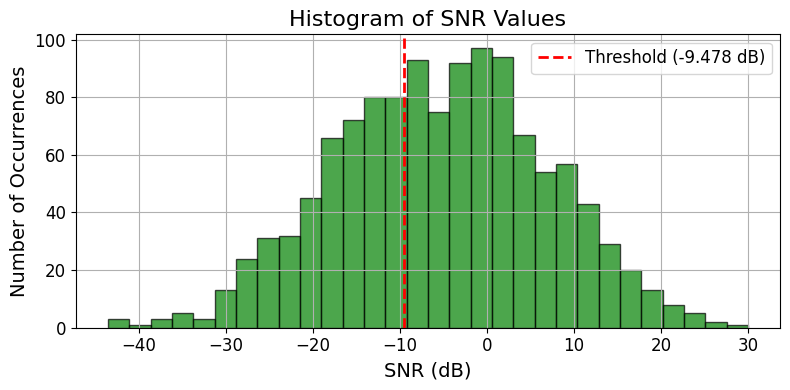

In [7]:
threshold = -9.478
below_threshold = sum(1 for value in snr_values if value < threshold)
unusable_channel = (below_threshold / len(snr_values)) * 100
print(f"{unusable_channel:.3f}% of the time poor channel conditions unable transmission")

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(snr_values, bins=30, color='g', edgecolor='black', alpha=0.7)
plt.axvline(x=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold} dB)')

plt.title("Histogram of SNR Values", fontsize=16)
plt.xlabel("SNR (dB)", fontsize=14)
plt.ylabel("Number of Occurrences", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


Recover information from the simulation

In [8]:
generated_tasks = []
offloaded_tasks = []
local_tasks = []
completed_local = []
completed_remote = []
dropped_local = []
dropped_remote = []
fairness = []
energy_saved_all = []


for user in users:
    generated_tasks.append(user.generated_tasks)
    offloaded_tasks.append(user.offloaded_tasks)
    local_tasks.append(user.generated_tasks-user.offloaded_tasks)
    dropped_local.append(user.dropped_local)
    dropped_remote.append(user.dropped_remote)
    completed_local.append(user.completed_local)
    completed_remote.append(user.completed_remote)
    fairness.append(user.completed_remote/user.offloaded_tasks if user.offloaded_tasks > 0 else 0)
    energy_saved_all.append(user.energy_saved)

print("generated_tasks:", generated_tasks)
print("completed_remote:", completed_remote)
print("completed_local:", completed_local)
print("offloaded_tasks:", offloaded_tasks)
print("dropped_remote:", dropped_remote)
print("dropped_local:", dropped_local)
print("fairness:", fairness)
print("energy_saved:", energy_saved_all)

generated_tasks: [129, 105, 120, 137, 116, 112, 142, 124, 116, 107]
completed_remote: [76, 55, 101, 99, 59, 57, 69, 65, 76, 69]
completed_local: [41, 45, 18, 33, 51, 49, 61, 53, 36, 35]
offloaded_tasks: [83, 57, 102, 101, 62, 57, 70, 66, 79, 71]
dropped_remote: [7, 2, 1, 2, 3, 0, 1, 1, 3, 2]
dropped_local: [5, 3, 0, 3, 3, 6, 11, 5, 1, 1]
fairness: [0.9156626506024096, 0.9649122807017544, 0.9901960784313726, 0.9801980198019802, 0.9516129032258065, 1.0, 0.9857142857142858, 0.9848484848484849, 0.9620253164556962, 0.971830985915493]
energy_saved: [152.1634565336357, 106.65216362690147, 187.552560843057, 188.13845607218383, 116.01117878528314, 104.38094809001487, 130.24142934156518, 120.319954029444, 150.46589955535265, 133.73371934750762]


Circular charts comparing offloading and local processing

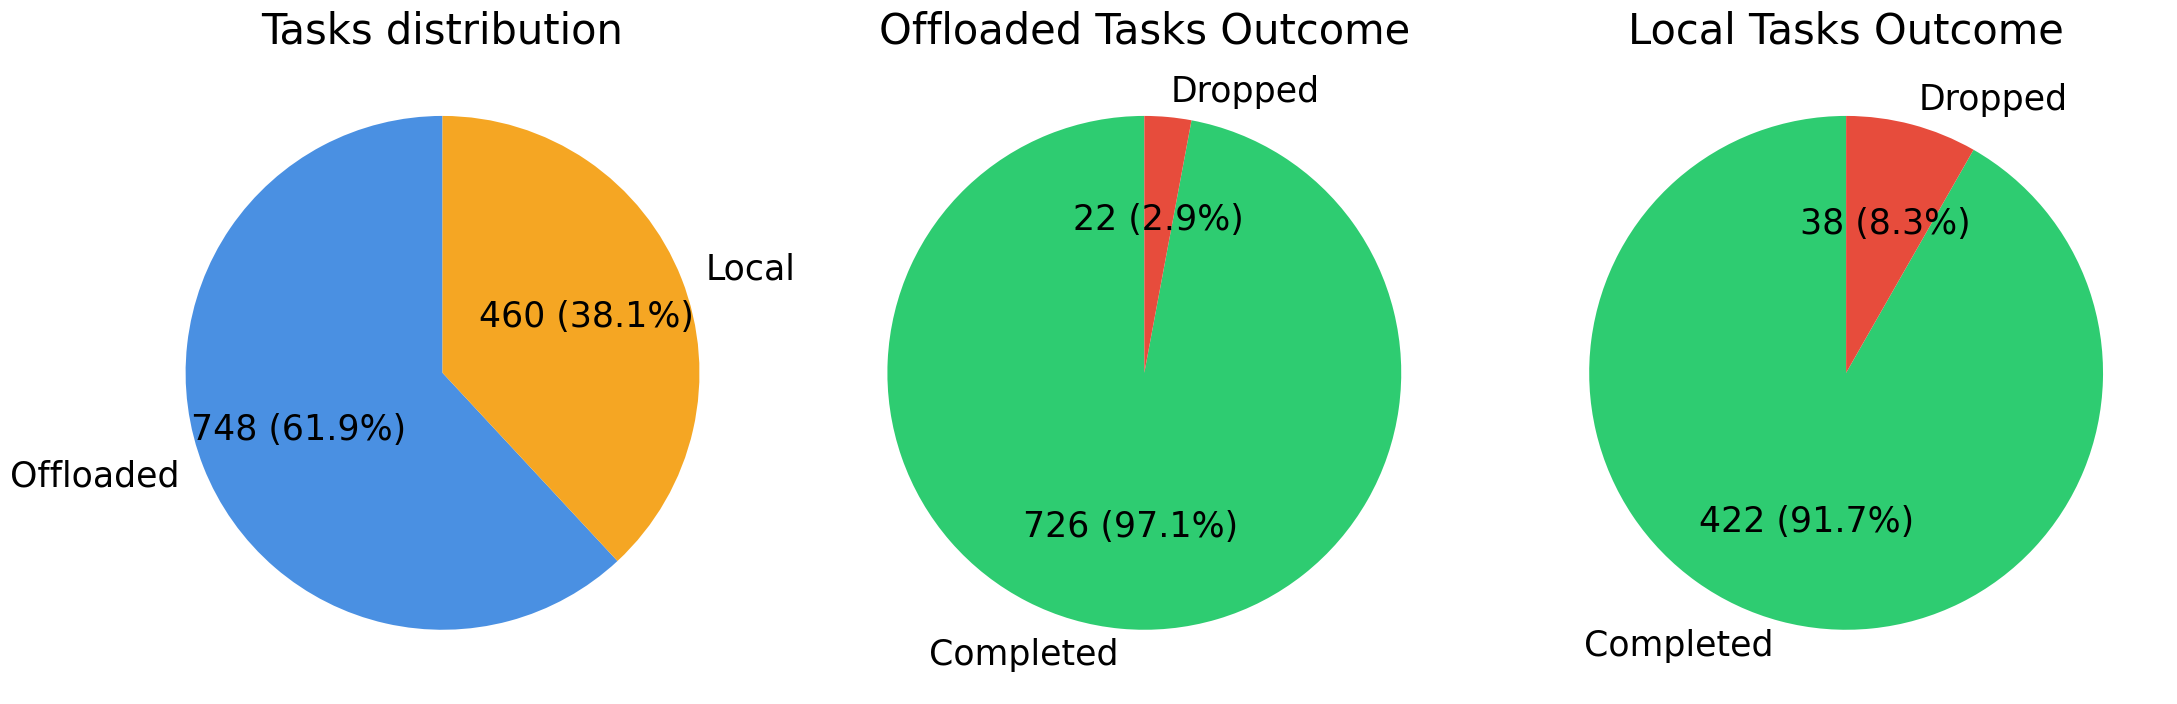

In [9]:
# Aggregate totals
total_offloaded = sum(offloaded_tasks)
total_local = sum(local_tasks)

completed_offload_total = sum(completed_remote)
dropped_offload_total = sum(dropped_remote)

completed_local_total = sum(completed_local)
dropped_local_total = sum(dropped_local)

# Custom label formatter (value + percentage)
def make_autopct(values):
    def autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val} ({pct:.1f}%)'
    return autopct

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

# Increased font sizes
label_fontsize = 27    # for labels on pie slices
number_fontsize = 25   # for autopct numbers
title_fontsize = 30    # for titles

# 1. Task Execution Mode
axes[0].pie(
    [total_offloaded, total_local],
    labels=['Offloaded', 'Local'],
    autopct=make_autopct([total_offloaded, total_local]),
    colors=['#4A90E2', '#F5A623'],
    startangle=90,
    textprops={'fontsize': label_fontsize}
)
axes[0].set_title('Tasks distribution', fontsize=title_fontsize)

# 2. Offloaded Tasks Outcome
axes[1].pie(
    [completed_offload_total, dropped_offload_total],
    labels=['Completed', 'Dropped'],
    autopct=make_autopct([completed_offload_total, dropped_offload_total]),
    colors=['#2ECC71', '#E74C3C'],
    startangle=90,
    textprops={'fontsize': label_fontsize}
)
axes[1].set_title('Offloaded Tasks Outcome', fontsize=title_fontsize)

# 3. Local Tasks Outcome
axes[2].pie(
    [completed_local_total, dropped_local_total],
    labels=['Completed', 'Dropped'],
    autopct=make_autopct([completed_local_total, dropped_local_total]),
    colors=['#2ECC71', '#E74C3C'],
    startangle=90,
    textprops={'fontsize': label_fontsize}
)
axes[2].set_title('Local Tasks Outcome', fontsize=title_fontsize)

# Manually set autopct font sizes (numbers inside pie slices)
for ax in axes:
    for text in ax.texts:
        text.set_fontsize(number_fontsize)

plt.tight_layout()
plt.show()


Latency plot


Local Latency Statistics:
Min: 0.5620 s
Max: 2.9270 s
Average: 1.2110 s
25th Percentile: 0.9072 s
50th Percentile (Median): 0.9930 s
75th Percentile: 1.4200 s

Remote Latency Statistics:
Min: 0.1340 s
Max: 2.0710 s
Average: 0.7280 s
25th Percentile: 0.4252 s
50th Percentile (Median): 0.6675 s
75th Percentile: 0.9865 s


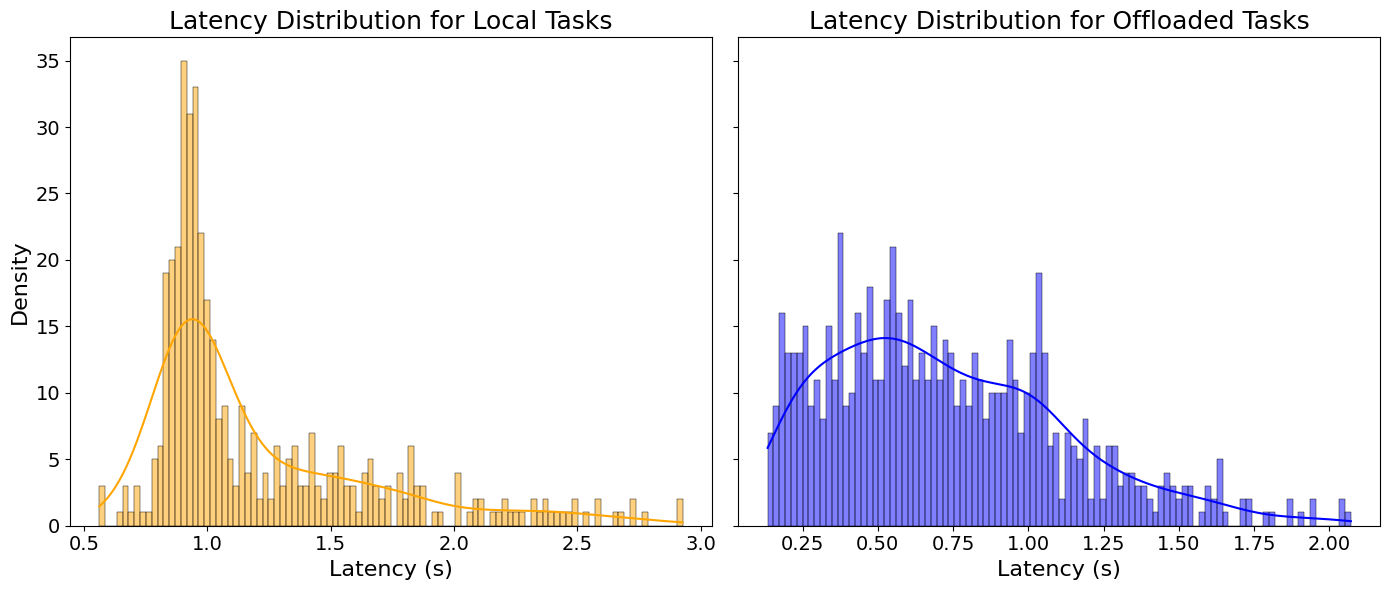

In [10]:
# Font size settings
title_fontsize = 18
label_fontsize = 16
tick_fontsize = 14

# Collect latency values
latency_local_values = []
latency_remote_values = []

for user in users:
    latency_local_values.extend(user.latency_local)
    latency_remote_values.extend(user.latency_remote)

# Convert to NumPy arrays
latency_local_array = np.array(latency_local_values)
latency_remote_array = np.array(latency_remote_values)

# Print statistics
def print_latency_stats(name, data):
    print(f"\n{name} Latency Statistics:")
    print(f"Min: {data.min():.4f} s")
    print(f"Max: {data.max():.4f} s")
    print(f"Average: {data.mean():.4f} s")
    print(f"25th Percentile: {np.percentile(data, 25):.4f} s")
    print(f"50th Percentile (Median): {np.percentile(data, 50):.4f} s")
    print(f"75th Percentile: {np.percentile(data, 75):.4f} s")

print_latency_stats("Local", latency_local_array)
print_latency_stats("Remote", latency_remote_array)

# Plot side-by-side distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot local latency
sns.histplot(latency_local_array, kde=True, bins=100, ax=axes[0], color='orange')
axes[0].set_title('Latency Distribution for Local Tasks', fontsize=title_fontsize)
axes[0].set_xlabel('Latency (s)', fontsize=label_fontsize)
axes[0].set_ylabel('Density', fontsize=label_fontsize)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)

# Plot remote latency
sns.histplot(latency_remote_array, kde=True, bins=100, ax=axes[1], color='blue')
axes[1].set_title('Latency Distribution for Offloaded Tasks', fontsize=title_fontsize)
axes[1].set_xlabel('Latency (s)', fontsize=label_fontsize)
axes[1].tick_params(axis='both', labelsize=tick_fontsize)

plt.tight_layout()
plt.show()


Bandwidth utilization Plot

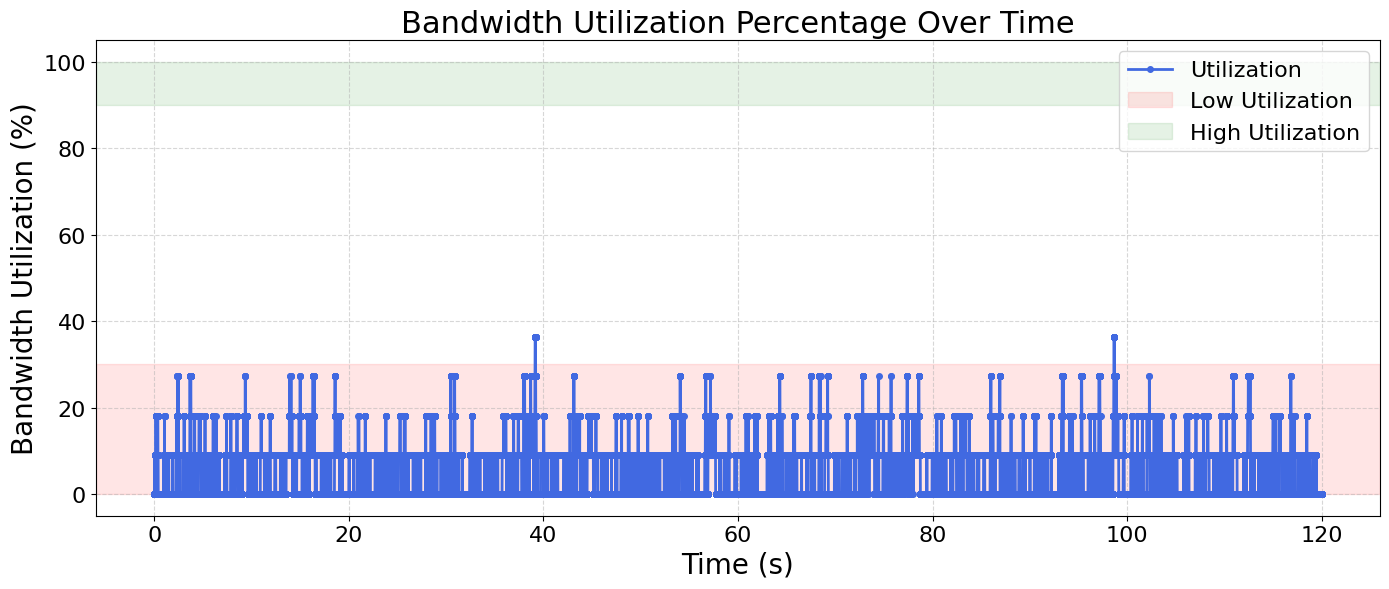

In [11]:
time_steps = np.linspace(0, total_time, sim_steps)
bandwidth_percent = np.array(bandwidth_utilization) * 100

# Font size variables
title_fontsize = 22
label_fontsize = 20
tick_fontsize = 16
legend_fontsize = 16

# Create plot
plt.figure(figsize=(14, 6))
plt.plot(time_steps, bandwidth_percent, color='royalblue', linewidth=2, linestyle='-', marker='o', markersize=4, label='Utilization')

# Highlight low and high utilization thresholds
plt.axhspan(0, 30, color='red', alpha=0.1, label='Low Utilization')
plt.axhspan(90, 100, color='green', alpha=0.1, label='High Utilization')

# Titles and labels with enhanced font sizes
plt.title("Bandwidth Utilization Percentage Over Time", fontsize=title_fontsize)
plt.xlabel("Time (s)", fontsize=label_fontsize)
plt.ylabel("Bandwidth Utilization (%)", fontsize=label_fontsize)

# Styling ticks and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=legend_fontsize, loc='upper right')

plt.tight_layout()
plt.show()


Average user energy utilization over time

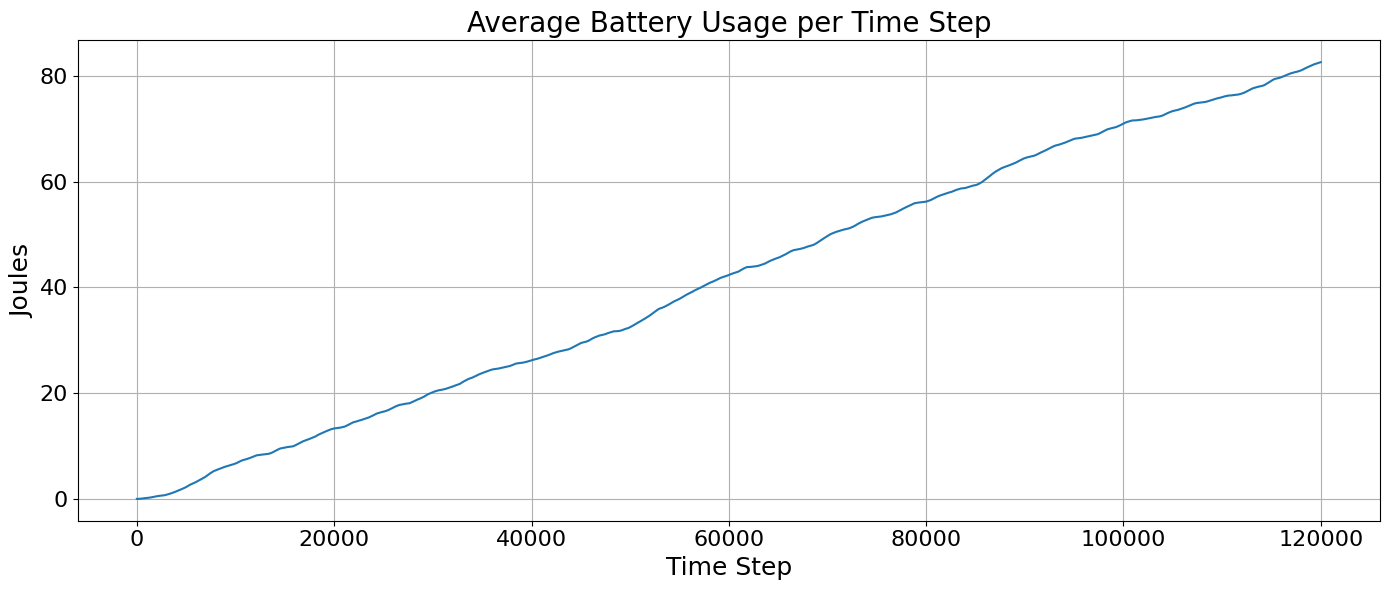

In [12]:
avg_battery_usage = np.mean([user.energy_used_over_time for user in users], axis=0)

plt.figure(figsize=(14, 6))
plt.plot(avg_battery_usage)
plt.title("Average Battery Usage per Time Step",fontsize = 20)
plt.xlabel("Time Step",fontsize = 18)
plt.ylabel("Joules",fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

Energy saved per user

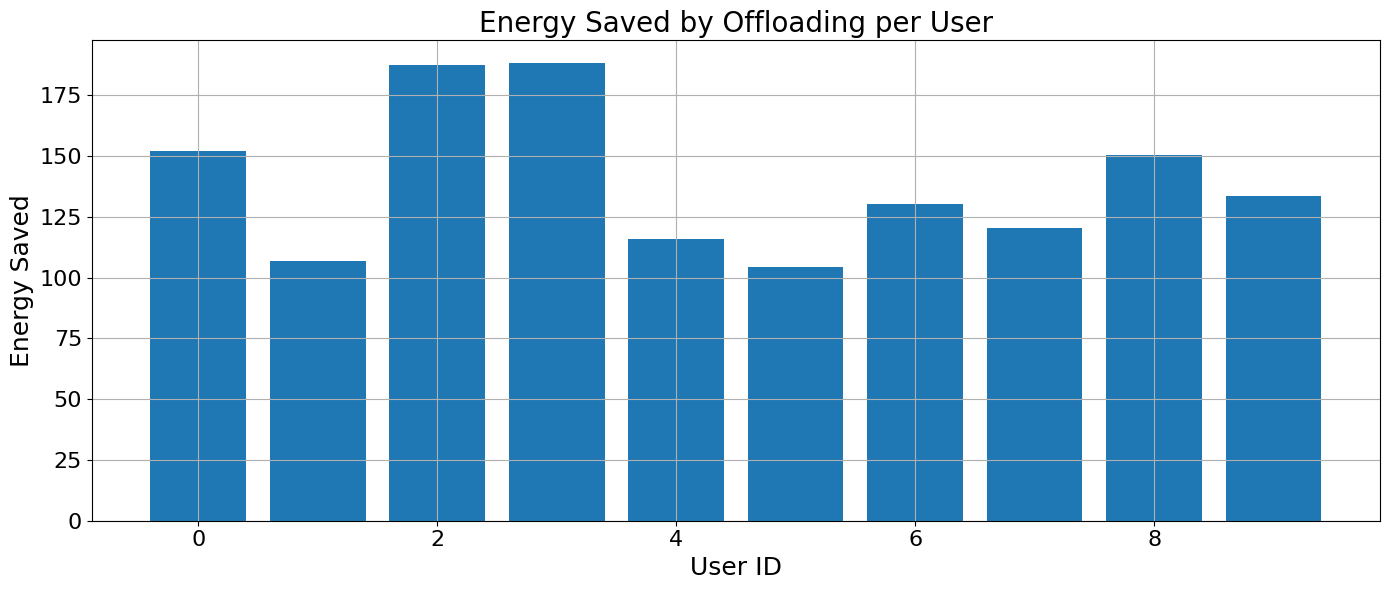

In [13]:
plt.figure(figsize=(14, 6))
plt.bar(range(len(energy_saved_all)), energy_saved_all)
plt.title("Energy Saved by Offloading per User",fontsize=20)
plt.xlabel("User ID",fontsize=18)
plt.ylabel("Energy Saved",fontsize=18)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

Energy plot

C:\Users\alvar\AppData\Local\Temp\ipykernel_18720\2157472111.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


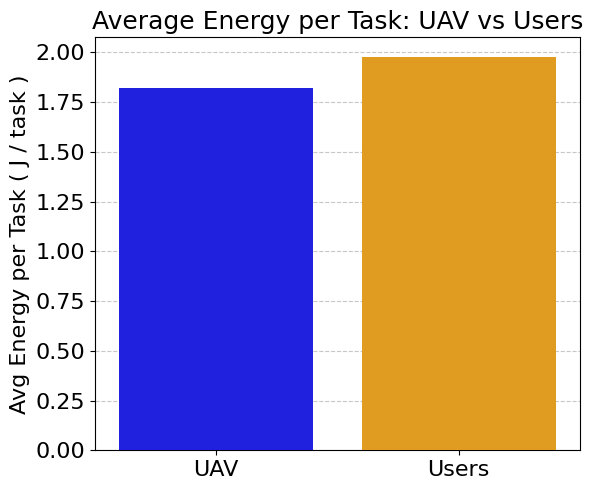

In [14]:

# Combine all users' computational energy into a single list
user_energy_all = []
for user in users:
    user_energy_all.extend(user.computational_energy)

# Convert to NumPy arrays for easy handling
uav_energy_array = np.array(uav.computational_energy)
user_energy_array = np.array(user_energy_all)

avg_uav_energy_per_task = np.sum(uav_energy_array) / sum(completed_remote)
avg_user_energy_per_task = np.sum(user_energy_array) / sum(completed_local)

# Font size variables
title_fontsize = 18
label_fontsize = 16
tick_fontsize = 16

plt.figure(figsize=(6, 5))

# Plot bars with higher zorder to appear above grid
sns.barplot(
    x=['UAV', 'Users'],
    y=[avg_uav_energy_per_task, avg_user_energy_per_task],
    palette=['blue', 'orange'],
    zorder=3  # bars above grid
)

plt.ylabel('Avg Energy per Task ( J / task )', fontsize=label_fontsize)
plt.title('Average Energy per Task: UAV vs Users', fontsize=title_fontsize)
plt.grid(True, axis='y', zorder=0, linestyle='--', alpha=0.7)

# Increase tick label sizes
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.tight_layout()
plt.show()


Fairness based on the Jain Index

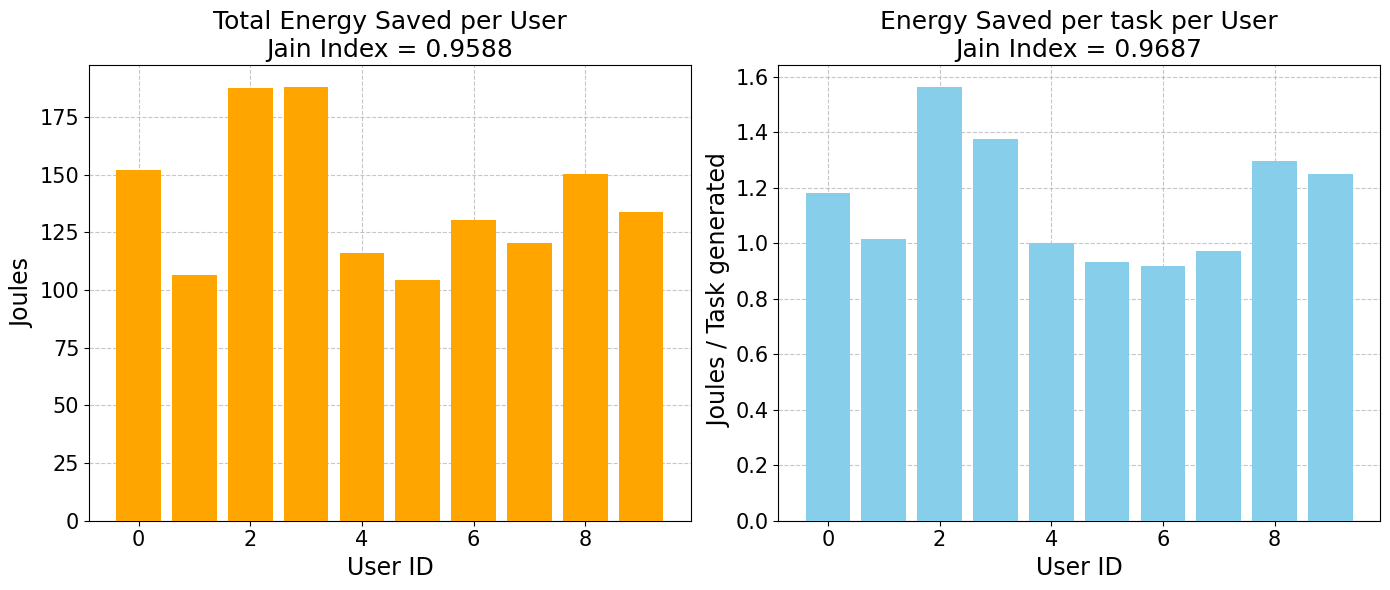

In [15]:
# Step 1: Flatten 
raw_energy_saved = [
    sum(es) if isinstance(es, list) else es 
    for es in energy_saved_all
]

# Step 2: Normalize energy saved by number of generated tasks
normalized_energy_saved = [
    es / gt if gt > 0 else 0 
    for es, gt in zip(raw_energy_saved, generated_tasks)
]

# Step 3: Compute Jain's Fairness Index
numerator_raw = sum(raw_energy_saved) ** 2
denominator_raw = len(raw_energy_saved) * sum(x**2 for x in raw_energy_saved)
jain_index_raw = numerator_raw / denominator_raw if denominator_raw != 0 else 0

numerator_norm = sum(normalized_energy_saved) ** 2
denominator_norm = len(normalized_energy_saved) * sum(x**2 for x in normalized_energy_saved)
jain_index_norm = numerator_norm / denominator_norm if denominator_norm != 0 else 0

# Font size variables
title_fontsize = 18
label_fontsize = 17
tick_fontsize = 15

# Step 4: Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Raw Energy Saved
axs[0].bar(range(len(raw_energy_saved)), raw_energy_saved, color='orange', zorder=3)
axs[0].set_title(f'Total Energy Saved per User\nJain Index = {jain_index_raw:.4f}', fontsize=title_fontsize)
axs[0].set_xlabel('User ID', fontsize=label_fontsize)
axs[0].set_ylabel('Joules', fontsize=label_fontsize)
axs[0].grid(True, zorder=0, linestyle='--', alpha=0.7)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)

# Plot 2: Normalized Energy Saved
axs[1].bar(range(len(normalized_energy_saved)), normalized_energy_saved, color='skyblue', zorder=3)
axs[1].set_title(f'Energy Saved per task per User\nJain Index = {jain_index_norm:.4f}', fontsize=title_fontsize)
axs[1].set_xlabel('User ID', fontsize=label_fontsize)
axs[1].set_ylabel(' Joules / Task generated', fontsize=label_fontsize)
axs[1].grid(True, zorder=0, linestyle='--', alpha=0.7)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)

plt.tight_layout()
plt.show()


Tasks generated, completed and dropped for each user

C:\Users\alvar\AppData\Local\Temp\ipykernel_18720\2215293665.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=tick_fontsize)
C:\Users\alvar\AppData\Local\Temp\ipykernel_18720\2215293665.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=tick_fontsize)


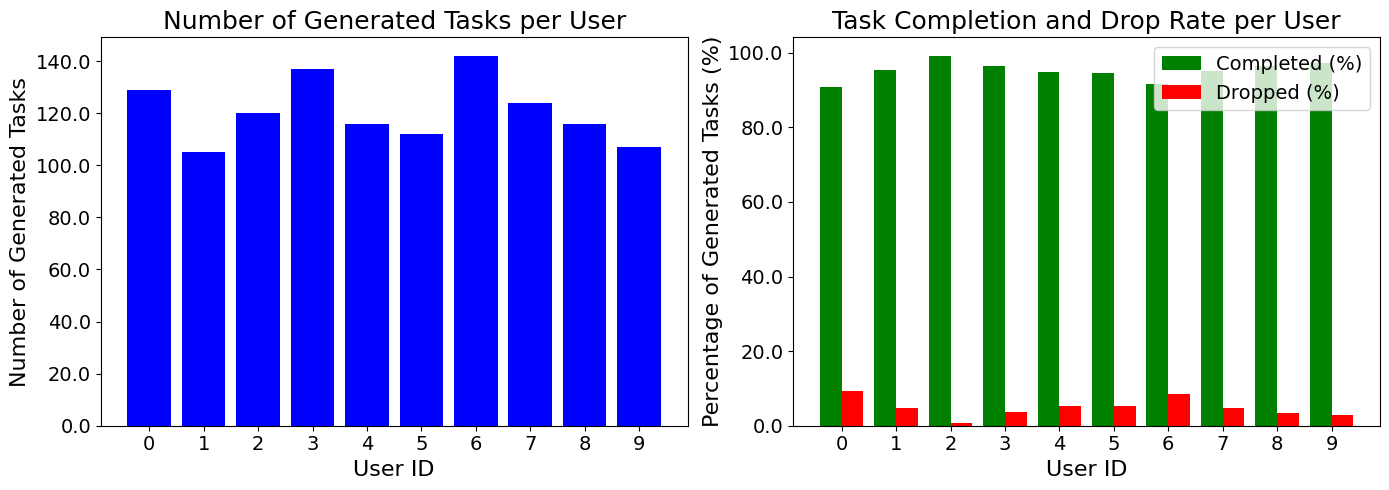

In [16]:
title_fontsize = 18
label_fontsize = 16
tick_fontsize = 14

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Generated tasks per user
ax[0].bar(range(len(generated_tasks)), generated_tasks, color='b')
ax[0].set_xlabel('User ID', fontsize=label_fontsize)
ax[0].set_ylabel('Number of Generated Tasks', fontsize=label_fontsize)
ax[0].set_xticks(range(len(generated_tasks)))
ax[0].set_xticklabels(range(len(generated_tasks)), fontsize=tick_fontsize)
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=tick_fontsize)
ax[0].set_title('Number of Generated Tasks per User', fontsize=title_fontsize)

# Compute completed and dropped totals
completed_tasks = [local + remote for local, remote in zip(completed_local, completed_remote)]
dropped_tasks = [local + remote for local, remote in zip(dropped_local, dropped_remote)]

# Calculate percentages safely
percentage_completed = [
    (completed / generated * 100) if generated > 0 else 0
    for completed, generated in zip(completed_tasks, generated_tasks)
]
percentage_dropped = [
    (dropped / generated * 100) if generated > 0 else 0
    for dropped, generated in zip(dropped_tasks, generated_tasks)
]

# Plot 2: Completed and Dropped Task Percentages
x = np.arange(len(generated_tasks))
bar_width = 0.4

ax[1].bar(x - bar_width/2, percentage_completed, width=bar_width, color='g', label='Completed (%)')
ax[1].bar(x + bar_width/2, percentage_dropped, width=bar_width, color='r', label='Dropped (%)')

ax[1].set_xlabel('User ID', fontsize=label_fontsize)
ax[1].set_ylabel('Percentage of Generated Tasks (%)', fontsize=label_fontsize)
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, fontsize=tick_fontsize)
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=tick_fontsize)
ax[1].set_title('Task Completion and Drop Rate per User', fontsize=title_fontsize)
ax[1].legend(fontsize=tick_fontsize)

plt.tight_layout()
plt.show()

Offloaded tasks for each user

C:\Users\alvar\AppData\Local\Temp\ipykernel_18720\708472984.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=tick_fontsize)
C:\Users\alvar\AppData\Local\Temp\ipykernel_18720\708472984.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=tick_fontsize)


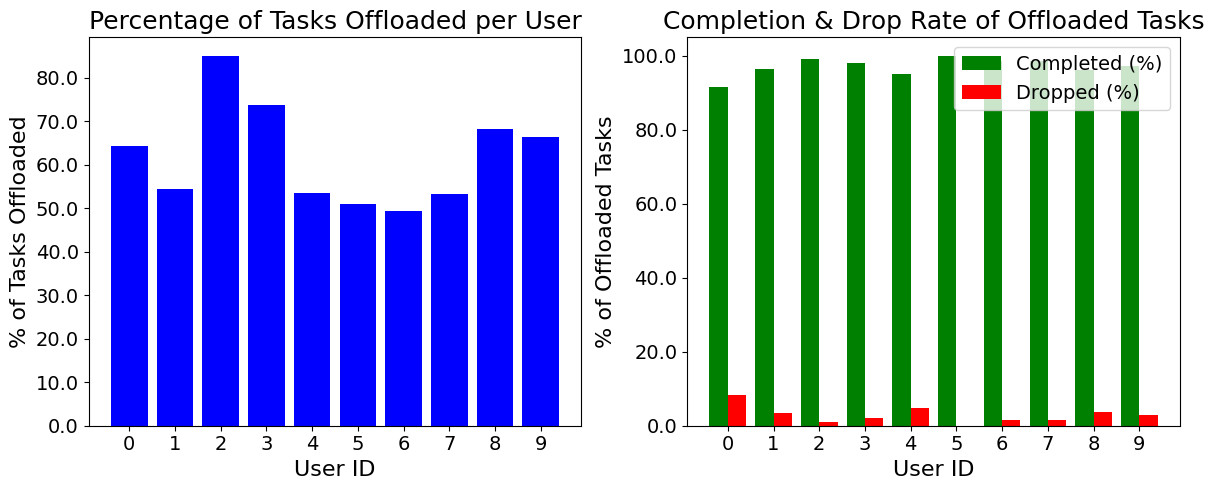

In [17]:
# Font size variables
title_fontsize = 18
label_fontsize = 16
tick_fontsize = 14

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: % Offloaded tasks compared to generated
percentage_offloaded = [
    (offloaded / generated * 100) if generated > 0 else 0
    for offloaded, generated in zip(offloaded_tasks, generated_tasks)
]
ax[0].bar(range(len(percentage_offloaded)), percentage_offloaded, color='b')
ax[0].set_xlabel('User ID', fontsize=label_fontsize)
ax[0].set_ylabel('% of Tasks Offloaded', fontsize=label_fontsize)
ax[0].set_xticks(range(len(percentage_offloaded)))
ax[0].set_xticklabels(range(len(percentage_offloaded)), fontsize=tick_fontsize)
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=tick_fontsize)
ax[0].set_title('Percentage of Tasks Offloaded per User', fontsize=title_fontsize)

# Plot 2: % Completed and Dropped of Offloaded tasks
percentage_completed_remote = [
    (completed / offloaded * 100) if offloaded > 0 else 0
    for completed, offloaded in zip(completed_remote, offloaded_tasks)
]
percentage_dropped_remote = [
    (dropped / offloaded * 100) if offloaded > 0 else 0
    for dropped, offloaded in zip(dropped_remote, offloaded_tasks)
]

x = np.arange(len(offloaded_tasks))
bar_width = 0.4

ax[1].bar(x - bar_width/2, percentage_completed_remote, width=bar_width, color='g', label='Completed (%)')
ax[1].bar(x + bar_width/2, percentage_dropped_remote, width=bar_width, color='r', label='Dropped (%)')

ax[1].set_xlabel('User ID', fontsize=label_fontsize)
ax[1].set_ylabel('% of Offloaded Tasks', fontsize=label_fontsize)
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, fontsize=tick_fontsize)
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=tick_fontsize)
ax[1].set_title('Completion & Drop Rate of Offloaded Tasks', fontsize=title_fontsize)
ax[1].legend(fontsize=tick_fontsize)

plt.tight_layout()
plt.show()


Local tasks for each user

C:\Users\alvar\AppData\Local\Temp\ipykernel_18720\498221572.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=tick_fontsize)
C:\Users\alvar\AppData\Local\Temp\ipykernel_18720\498221572.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=tick_fontsize)


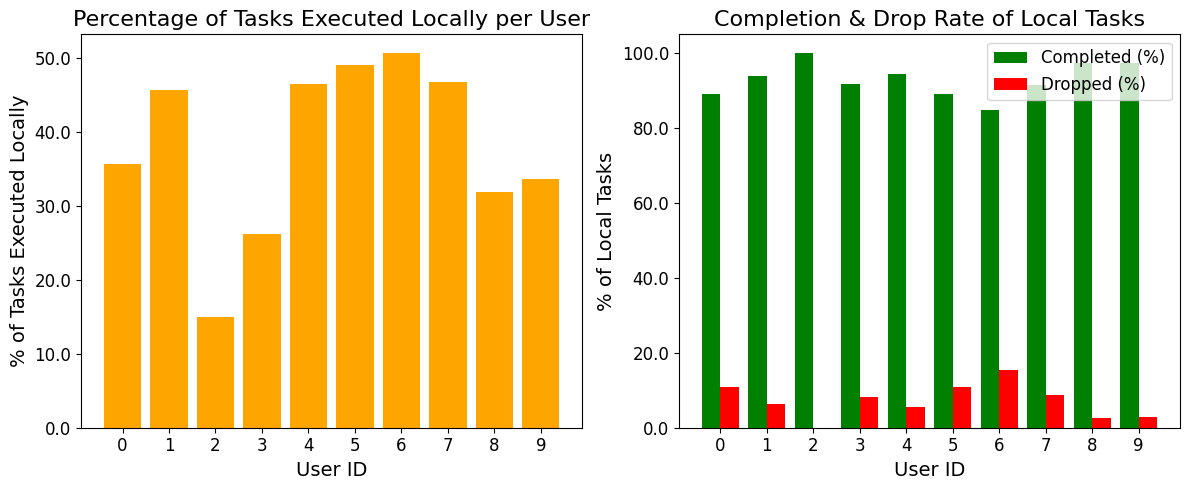

In [18]:
# Font size variables
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: % Locally executed tasks compared to generated
percentage_local = [
    (local / generated * 100) if generated > 0 else 0
    for local, generated in zip(local_tasks, generated_tasks)
]
ax[0].bar(range(len(percentage_local)), percentage_local, color='orange')
ax[0].set_xlabel('User ID', fontsize=label_fontsize)
ax[0].set_ylabel('% of Tasks Executed Locally', fontsize=label_fontsize)
ax[0].set_xticks(range(len(percentage_local)))
ax[0].set_xticklabels(range(len(percentage_local)), fontsize=tick_fontsize)
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=tick_fontsize)
ax[0].set_title('Percentage of Tasks Executed Locally per User', fontsize=title_fontsize)

# Plot 2: % Completed and Dropped of Local tasks
percentage_completed_local = [
    (completed / local * 100) if local > 0 else 0
    for completed, local in zip(completed_local, local_tasks)
]
percentage_dropped_local = [
    (dropped / local * 100) if local > 0 else 0
    for dropped, local in zip(dropped_local, local_tasks)
]

x = np.arange(len(local_tasks))
bar_width = 0.4

ax[1].bar(x - bar_width/2, percentage_completed_local, width=bar_width, color='g', label='Completed (%)')
ax[1].bar(x + bar_width/2, percentage_dropped_local, width=bar_width, color='r', label='Dropped (%)')

ax[1].set_xlabel('User ID', fontsize=label_fontsize)
ax[1].set_ylabel('% of Local Tasks', fontsize=label_fontsize)
ax[1].set_xticks(x)
ax[1].set_xticklabels(x, fontsize=tick_fontsize)
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=tick_fontsize)
ax[1].set_title('Completion & Drop Rate of Local Tasks', fontsize=title_fontsize)
ax[1].legend(fontsize=tick_fontsize)

plt.tight_layout()
plt.show()

Completion ratio for offloaded tasks

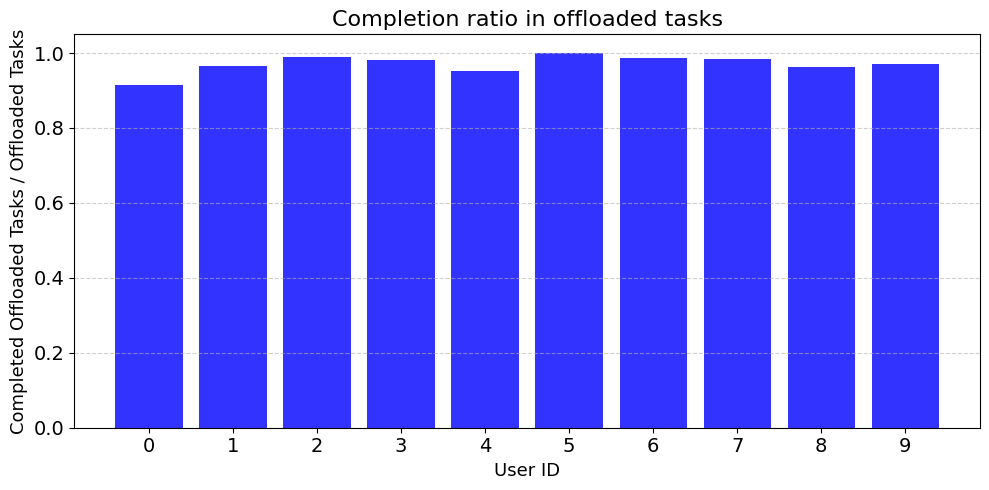

In [19]:
# Font size variables
title_fontsize = 16
label_fontsize = 13
tick_fontsize = 14

plt.figure(figsize=(10, 5))
plt.bar(range(len(fairness)), fairness, color='b', alpha=0.8)

plt.xlabel('User ID', fontsize=label_fontsize)
plt.ylabel('Completed Offloaded Tasks / Offloaded Tasks', fontsize=label_fontsize)
plt.xticks(range(len(fairness)), fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.title('Completion ratio in offloaded tasks', fontsize=title_fontsize)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


UAV Available Energy

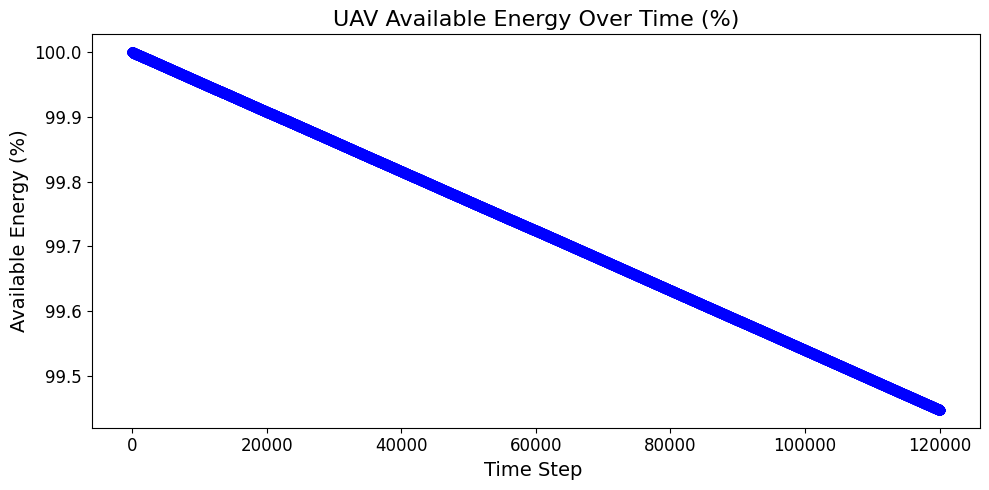

In [20]:
# Font size variables
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12

# Convert energy to percentages
max_energy = max(energy_vect) if max(energy_vect) != 0 else 1  # avoid division by zero
energy_percent = [(e / max_energy) * 100 for e in energy_vect]

plt.figure(figsize=(10, 5))
plt.plot(energy_percent, marker='o', linestyle='-', color='b')

plt.title("UAV Available Energy Over Time (%)", fontsize=title_fontsize)
plt.xlabel("Time Step ", fontsize=label_fontsize)
plt.ylabel("Available Energy (%)", fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.tight_layout()
plt.show()
